In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy

import utils
import som

import PIL
import PIL.ImageDraw
import cv2

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6617.75it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [8]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'pineapple', 'fruity', 'sweet', 'cherry', 'banana', 'tropical'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [20]:
dists = []
sims = []
for i, mol1 in enumerate(tqdm.tqdm(molecules[:300])):
    for j, mol2 in enumerate(molecules[:300]):
        enc1, enc2 = mol1["encoding"], mol2["encoding"]
        dists.append(torch.linalg.norm(enc1-enc2))
        sims.append(torch.nn.functional.cosine_similarity(enc1,enc2,dim=0))

100%|█████████████████████████████████████████| 300/300 [00:07<00:00, 41.17it/s]


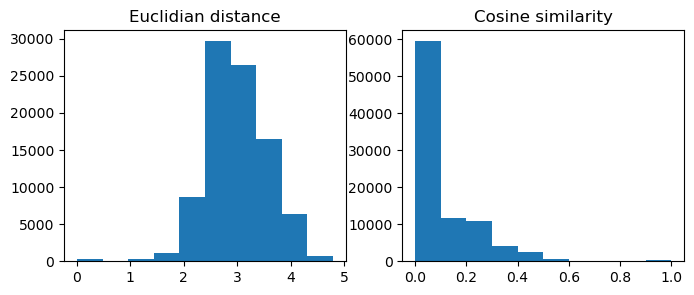

In [23]:
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].hist(dists)
axs[0].set_title("Euclidian distance")
axs[1].hist(sims)
axs[1].set_title("Cosine similarity")
plt.show()